In [1]:
# ==============================================================================
# Cell 1: Setup and Configuration (WGAN-GP Version) - FIXED
# ==============================================================================

# --- 1.1. Install necessary libraries ---
# !pip install numpy scipy scikit-learn matplotlib seaborn pandas mne --quiet

# --- 1.2. Imports ---
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from scipy import signal
from scipy.linalg import sqrtm
from sklearn.decomposition import PCA
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

# --- 1.3. Configuration & Setup ---
OUTPUT_DIR = "/kaggle/working/"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Model and Data Parameters
DATA_PATH = "/kaggle/input/mpi-lemon-eeg/lemon_preprocessed_8ch_512ts.npy"
CHANNELS = 8
TIMESTEPS = 512
LATENT_DIM = 100
NUM_CLASSES = 2 # Note: Using dummy classes for this setup

# Training Hyperparameters for WGAN-GP
NUM_EPOCHS = 600 # WGAN-GP can take longer to converge, but is more stable
BATCH_SIZE = 64
LR = 1e-4 # A common, stable learning rate for WGAN-GP
BETA1 = 0.0 # Recommended beta for WGAN-GP
BETA2 = 0.9
CRITIC_ITERATIONS = 5 # Train critic more often, which is standard for WGANs
LAMBDA_GP = 10.0 # Gradient penalty coefficient, as recommended in the WGAN-GP paper
DIVERSITY_WEIGHT = 0.1 # Mode-seeking loss can be smaller as GP helps with diversity

# Evaluation
SAVE_INTERVAL = 50

# --- Setup device ---
torch.manual_seed(42)
np.random.seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print("Configuration set for WGAN-GP training.")

Using device: cuda
Configuration set for WGAN-GP training.


In [2]:
# ==============================================================================
# Cell 2: Load and Scale Preprocessed Data - FIXED
# ==============================================================================

try:
    # --- 1. Load the original data ---
    data = np.load(DATA_PATH)
    print(f"Successfully loaded original data. Shape: {data.shape}")
    
    # --- 2. Keep a copy of the original data for final evaluation ---
    # We will use this in Cell 6 to generate plots in the original amplitude range.
    original_data_for_eval = data[:2048].copy() # Store a large, representative batch
    
    # --- 3. Calculate the scaling factor and apply it ---
    # This is the core of Solution A. We scale the data to fit into the [-1, 1] range
    # that the generator's Tanh activation function produces.
    scale_factor = np.max(np.abs(data))
    data = data / scale_factor
    print(f"Data scaled by factor: {scale_factor:.4f}. New min/max: {data.min():.4f} / {data.max():.4f}")
    
    # --- 4. Create the DataLoader with the SCALED data ---
    # The rest of the notebook will now train on data that is correctly scaled.
    labels = np.random.randint(0, NUM_CLASSES, data.shape[0])
    
    dataset = TensorDataset(torch.from_numpy(data).float(), torch.from_numpy(labels).long())
    dataloader = DataLoader(
        dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=2,
        pin_memory=True
    )
    print("Created DataLoader successfully with SCALED data.")
    
except FileNotFoundError:
    print(f"ERROR: Data file not found at '{DATA_PATH}'.")
    print("Please ensure your preprocessed .npy file is in a Kaggle Dataset and that the dataset is added to this notebook.")
except Exception as e:
    print(f"An error occurred: {e}")

Successfully loaded original data. Shape: (35503, 512, 8)
Data scaled by factor: 20.0000. New min/max: -0.9318 / 1.0000
Created DataLoader successfully with SCALED data.


In [3]:
# ==============================================================================
# Cell 3: Model Architectures with Tanh Activation - FIXED
# ==============================================================================

from torch.nn.utils import spectral_norm

class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResBlock, self).__init__()
        self.conv_block = nn.Sequential(
            nn.BatchNorm1d(in_channels), 
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm1d(out_channels), 
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(out_channels, out_channels, kernel_size=3, padding=1)
        )
        self.shortcut = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv1d(in_channels, out_channels, kernel_size=1)
        )
        
    def forward(self, x):
        return self.conv_block(x) + self.shortcut(x)

class ResGenerator(nn.Module):
    def __init__(self, latent_dim, num_classes, channels, timesteps):
        super(ResGenerator, self).__init__()
        self.initial_len = timesteps // 16
        self.label_emb = nn.Embedding(num_classes, latent_dim)
        self.fc = nn.Linear(latent_dim * 2, 256 * self.initial_len)
        self.res_blocks = nn.Sequential(
            ResBlock(256, 128), 
            ResBlock(128, 64), 
            ResBlock(64, 32), 
            ResBlock(32, 16)
        )
        
        # --- KEY CHANGE: Added nn.Tanh() for smooth, bounded output ---
        self.final_conv = nn.Sequential(
            nn.BatchNorm1d(16), 
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(16, channels, kernel_size=3, padding=1),
            nn.Tanh() # Output is now in [-1, 1]
        )
        
    def forward(self, noise, labels):
        c = self.label_emb(labels)
        x = torch.cat([noise, c], 1)
        x = self.fc(x)
        x = x.reshape(x.size(0), 256, self.initial_len)
        x = self.res_blocks(x)
        x = self.final_conv(x)
        return x.transpose(1, 2)

# The Discriminator is well-suited for WGAN-GP and remains unchanged.
class V6InspiredDiscriminator(nn.Module):
    def __init__(self, num_classes, channels, timesteps):
        super(V6InspiredDiscriminator, self).__init__()
        self.channels = channels
        self.timesteps = timesteps
        self.embedding_size = channels * timesteps
        self.label_emb = nn.Embedding(num_classes, self.embedding_size)
        
        self.conv_layers = nn.Sequential(
            spectral_norm(nn.Conv1d(channels * 2, 128, 5, 2, 2)), 
            nn.LeakyReLU(0.2, inplace=True),
            spectral_norm(nn.Conv1d(128, 256, 5, 2, 2)), 
            nn.LeakyReLU(0.2, inplace=True),
            spectral_norm(nn.Conv1d(256, 512, 5, 2, 2)), 
            nn.LeakyReLU(0.2, inplace=True),
        )
        
        with torch.no_grad():
            dummy_input = torch.randn(1, channels * 2, timesteps)
            conv_out_size = self.conv_layers(dummy_input).reshape(1, -1).size(1)
            
        self.classifier = nn.Sequential(
            spectral_norm(nn.Linear(conv_out_size, 1024)), 
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.5),
            spectral_norm(nn.Linear(1024, 1))
        )
        
    def forward(self, eeg, labels):
        x = eeg.transpose(1, 2)
        c = self.label_emb(labels).reshape(-1, self.channels, self.timesteps)
        x = torch.cat([x, c], dim=1)
        x = self.conv_layers(x)
        x = x.reshape(x.size(0), -1)
        return self.classifier(x)

print("Model architectures defined (Generator with Tanh).")


Model architectures defined (Generator with Tanh).


In [4]:
# ==============================================================================
# Cell 6: The Ultimate Visualization Suite (Upgraded for Publication)
# ==============================================================================
# This cell contains all plotting functions needed to replicate the YARE-GAN paper's figures.

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import skew, kurtosis
from scipy import signal
import umap
import hdbscan

def plot_figure_2(history, save_path):
    """Generates the 5-panel training statistics plot (YARE-GAN Figure 2)."""
    fig, axes = plt.subplots(3, 2, figsize=(18, 15))
    fig.delaxes(axes[2, 1])  # Remove the empty subplot
    axes = axes.flatten()
    
    epochs = np.arange(1, len(history['g_loss']) + 1)
    
    # (a) Generator Loss
    axes[0].plot(epochs, history['g_loss'], label='Generator Loss', color='blue')
    axes[0].set_title('Generator Loss')
    axes[0].set_xlabel('Training Step')
    axes[0].set_ylabel('Loss')
    
    # (b) Critic Loss
    axes[1].plot(epochs, history['d_loss'], label='Critic Loss', color='red')
    axes[1].set_title('Critic Loss')
    axes[1].set_xlabel('Training Step')
    axes[1].set_ylabel('Loss')

    # (c) Gradient Penalty
    axes[2].plot(epochs, history['gp'], label='Gradient Penalty', color='green')
    axes[2].set_title('Gradient Penalty')
    axes[2].set_xlabel('Training Step')
    axes[2].set_ylabel('Value')
    
    # (d) Critic Gradient Norm
    axes[3].plot(epochs, history['grad_norm'], label='Critic Gradient Norm', color='purple')
    axes[3].set_title('Critic Gradient Norm')
    axes[3].set_xlabel('Training Step')
    axes[3].set_ylabel('Norm')
    
    # (e) Fake and Real Predictions
    axes[4].plot(epochs, history['real_pred'], label='Real Prediction', color='blue')
    axes[4].plot(epochs, history['fake_pred'], label='Fake Prediction', color='orange')
    axes[4].set_title('Fake and Real Prediction')
    axes[4].set_xlabel('Training Step')
    axes[4].set_ylabel('Critic Output')
    
    for ax in axes[:5]:
        ax.legend()
        ax.grid(True, linestyle='--')
        
    plt.tight_layout()
    fig.suptitle('Training Statistics', fontsize=20, y=1.02)
    plt.savefig(save_path)
    plt.close()
    print("Generated training statistics plot (Figure 2).")


def plot_figure_3(real_data, gen_data, save_path_prefix):
    """Generates plots for Figure 3a (PCA) and 3b (Histogram)."""
    pca = PCA(n_components=2)
    real_flat, gen_flat = real_data.reshape(real_data.shape[0], -1), gen_data.reshape(gen_data.shape[0], -1)
    pca.fit(real_flat)
    real_pca, gen_pca = pca.transform(real_flat), pca.transform(gen_flat)

    plt.figure(figsize=(10, 10))
    plt.scatter(real_pca[:, 0], real_pca[:, 1], alpha=0.5, label='Real EEG', s=15, c='blue')
    plt.scatter(gen_pca[:, 0], gen_pca[:, 1], alpha=0.5, label='Generated EEG', s=15, c='orange')
    plt.title('PCA Distribution of Real vs. Generated Data', fontsize=16)
    plt.xlabel('PC 1', fontsize=12)
    plt.ylabel('PC 2', fontsize=12)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.savefig(f"{save_path_prefix}_fig3a_pca.png")
    plt.close()

    plt.figure(figsize=(12, 7))
    sns.histplot(real_data.flatten(), color="blue", label='Real', stat='density', bins=100, alpha=0.7)
    sns.histplot(gen_data.flatten(), color="orange", label='Generated', stat='density', bins=100, alpha=0.7)
    plt.title('Global Amplitude Distribution', fontsize=16)
    plt.xlabel('Amplitude (Normalized)', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.legend()
    plt.savefig(f"{save_path_prefix}_fig3b_histogram.png")
    plt.close()
    print("Generated distribution plots (PCA, Histogram - Figure 3).")

def plot_figure_4(real_data, gen_data, save_path_prefix):
    """Generates per-channel PSD and Time-Series plots."""
    channel_names = ['F1', 'F2', 'C1', 'C2', 'P1', 'P2', 'O1', 'O2']
    sfreq = 98

    # PSD Plots
    fig, axes = plt.subplots(4, 2, figsize=(18, 24), sharex=True, sharey=True)
    axes = axes.flatten()
    for i in range(real_data.shape[2]):
        f_real, psd_real = signal.welch(real_data[:, :, i], fs=sfreq, axis=1, nperseg=sfreq*2)
        f_gen, psd_gen = signal.welch(gen_data[:, :, i], fs=sfreq, axis=1, nperseg=sfreq*2)
        mean_psd_real, std_psd_real = np.mean(np.log10(psd_real + 1e-12), 0), np.std(np.log10(psd_real + 1e-12), 0)
        mean_psd_gen, std_psd_gen = np.mean(np.log10(psd_gen + 1e-12), 0), np.std(np.log10(psd_gen + 1e-12), 0)
        ax = axes[i]
        ax.plot(f_real, mean_psd_real, label='Real', color='blue')
        ax.fill_between(f_real, mean_psd_real - std_psd_real, mean_psd_real + std_psd_real, color='blue', alpha=0.2)
        ax.plot(f_gen, mean_psd_gen, label='Generated', color='orange')
        ax.fill_between(f_gen, mean_psd_gen - std_psd_gen, mean_psd_gen + std_psd_gen, color='orange', alpha=0.2)
        ax.set_title(f'Channel: {channel_names[i]}', fontsize=14)
        ax.set_xlabel('Frequency (Hz)')
        ax.set_ylabel('Log Power/Hz')
        ax.legend()
        ax.grid(True, linestyle='--')
        ax.set_xlim(0, 45)
    plt.tight_layout()
    plt.savefig(f"{save_path_prefix}_fig4_psd.png")
    plt.close()
    
    # Time-Series Plots
    fig, axes = plt.subplots(4, 2, figsize=(18, 12), sharex=True, sharey=True)
    axes = axes.flatten()
    time_axis = np.arange(real_data.shape[1]) / sfreq
    for i in range(real_data.shape[2]):
        ax = axes[i]
        ax.plot(time_axis, real_data[0, :, i], label='Real', color='blue', alpha=0.8)
        ax.plot(time_axis, gen_data[0, :, i], label='Generated', color='orange', alpha=0.8)
        ax.set_title(f'Channel: {channel_names[i]}', fontsize=14)
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Amplitude (uV)')
        ax.legend()
    plt.tight_layout()
    plt.savefig(f"{save_path_prefix}_fig4_timeseries.png")
    plt.close()
    print("Generated PSD and Time-Series plots (Figure 4).")

def plot_figure_5(real_data, gen_data, save_path_prefix):
    """Generates functional connectivity plots."""
    real_flat = real_data.reshape(-1, real_data.shape[2])
    gen_flat = gen_data.reshape(-1, gen_data.shape[2])
    conn_real = cosine_similarity(real_flat.T)
    conn_gen = cosine_similarity(gen_flat.T)
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    sns.heatmap(conn_real, ax=axes[0], annot=True, fmt='.2f', cmap='viridis', vmin=0, vmax=1)
    axes[0].set_title('Real EEG Connectivity', fontsize=16)
    sns.heatmap(conn_gen, ax=axes[1], annot=True, fmt='.2f', cmap='viridis', vmin=0, vmax=1)
    axes[1].set_title('Generated EEG Connectivity', fontsize=16)
    fig.suptitle('Functional Connectivity Comparison', fontsize=20)
    plt.savefig(f"{save_path_prefix}_fig5_connectivity.png")
    plt.close()
    print("Generated connectivity plots (Figure 5).")

def plot_figure_6_detailed(fd_history, save_interval, save_path):
    """Generates the detailed, multi-panel Fréchet Distance plots."""
    epochs = (np.arange(len(fd_history)) + 1) * save_interval
    spectral_keys = ['FD delta', 'FD theta', 'FD alpha', 'FD beta', 'FD gamma']
    time_keys = ['FD skewness', 'FD kurtosis', 'FD complexity', 'FD mobility', 'FD activity']
    
    fig, axes = plt.subplots(2, 5, figsize=(25, 10), sharex=True)
    
    # Upper row: Spectral Features
    for i, key in enumerate(spectral_keys):
        values = [d[key] for d in fd_history]
        axes[0, i].plot(epochs, values, '-o')
        axes[0, i].set_title(key.replace('FD ', '').capitalize())
        axes[0, i].grid(True, linestyle='--')
        if i == 0: 
            axes[0, i].set_ylabel('Fréchet Distance')

    # Lower row: Time-Domain Features
    for i, key in enumerate(time_keys):
        values = [d[key] for d in fd_history]
        axes[1, i].plot(epochs, values, '-o')
        axes[1, i].set_title(key.replace('FD ', '').capitalize())
        axes[1, i].grid(True, linestyle='--')
        axes[1, i].set_xlabel('Epoch')
        if i == 0: 
            axes[1, i].set_ylabel('Fréchet Distance')

    fig.suptitle('Detailed Fréchet Distance Progression Over Training', fontsize=22)
    plt.savefig(save_path)
    plt.close()
    print("Generated detailed FD progression plot (Figure 6).")
    
def plot_figure_12_pca_progression(pca_history, save_path):
    """Plots the progression of the PCA distribution over training."""
    num_plots = len(pca_history)
    cols = min(num_plots, 5)
    rows = (num_plots + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5), sharex=True, sharey=True)
    
    # Handle case where we only have one row
    if rows == 1:
        axes = axes.reshape(1, -1)
    axes = axes.flatten()

    for i, data in enumerate(pca_history):
        epoch, real_pca, gen_pca = data
        ax = axes[i]
        ax.scatter(real_pca[:, 0], real_pca[:, 1], alpha=0.3, s=10, c='blue', label='Real')
        ax.scatter(gen_pca[:, 0], gen_pca[:, 1], alpha=0.3, s=10, c='orange', label='Generated')
        ax.set_title(f'Epoch {epoch}')
        ax.set_xlim(-35, 35)
        ax.set_ylim(-35, 35)  # Set consistent limits
        ax.grid(True, linestyle='--')
    
    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)
        
    fig.suptitle("Progression of PCA Distribution Over Training", fontsize=20)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig(save_path)
    plt.close()
    print("Generated PCA progression plot (Figure 12).")

print("Ultimate evaluation and plotting suite defined.")

2025-06-28 20:24:29.997096: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751142270.188703      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751142270.241310      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Ultimate evaluation and plotting suite defined.


In [5]:
# ==============================================================================
# Cell 7: The WGAN-GP Training Loop (Upgraded for Metrics - CORRECTED)
# ==============================================================================

# --- HELPER FUNCTIONS FOR DETAILED FD CALCULATION ---
# This version is corrected to produce 2D feature arrays.
def get_detailed_features(data, sfreq=98):
    data_t = data.transpose(0, 2, 1) # (N, C, T)
    bands = {'delta': (0.5, 4), 'theta': (4, 8), 'alpha': (8, 13), 'beta': (13, 30), 'gamma': (30, 45)}
    freqs, psd = signal.welch(data_t, fs=sfreq, axis=2, nperseg=sfreq*2)
    
    # THE FIX: Remove .flatten() to keep the (n_samples, n_channels) structure.
    spectral_features = {
        f'FD {band_name}': np.mean(psd[:, :, np.logical_and(freqs >= b[0], freqs <= b[1])], axis=2)
        for band_name, b in bands.items()
    }
    
    dx = np.diff(data_t, axis=2); var_x, var_dx = np.var(data_t, axis=2), np.var(dx, axis=2)
    activity = var_x; mobility = np.sqrt(var_dx / (var_x + 1e-8)); 
    complexity = np.sqrt(np.var(np.diff(dx, axis=2), axis=2) / (var_dx + 1e-8)) / (mobility + 1e-8)
    
    # THE FIX: Remove .flatten() here as well.
    time_features = {
        'FD activity': activity,
        'FD mobility': mobility,
        'FD complexity': complexity,
        'FD skewness': skew(data_t, axis=2),
        'FD kurtosis': kurtosis(data_t, axis=2)
    }
    
    return {**spectral_features, **time_features}

def calculate_detailed_frechet_distance(real_features, gen_features):
    scores = {}
    for key in real_features.keys():
        mu1, sigma1 = np.mean(real_features[key], axis=0), np.cov(real_features[key], rowvar=False)
        mu2, sigma2 = np.mean(gen_features[key], axis=0), np.cov(gen_features[key], rowvar=False)
        ssdiff = np.sum((mu1 - mu2)**2.0)
        covmean = sqrtm(sigma1.dot(sigma2))
        if np.iscomplexobj(covmean): covmean = covmean.real
        fd = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
        scores[key] = fd
    return scores

def compute_gradient_penalty(discriminator, real_samples, fake_samples, labels, device):
    """Calculates the gradient penalty loss for WGAN GP"""
    alpha = torch.rand(real_samples.size(0), 1, 1, device=device)
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = discriminator(interpolates, labels)
    gradients = torch.autograd.grad(
        outputs=d_interpolates, inputs=interpolates,
        grad_outputs=torch.ones(d_interpolates.size(), device=device),
        create_graph=True, retain_graph=True, only_inputs=True,
    )[0]
    gradients = gradients.reshape(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

# --- Model and Optimizer Setup ---
generator = ResGenerator(LATENT_DIM, NUM_CLASSES, CHANNELS, TIMESTEPS).to(device)
discriminator = V6InspiredDiscriminator(NUM_CLASSES, CHANNELS, TIMESTEPS).to(device)
g_optimizer = optim.Adam(generator.parameters(), lr=LR, betas=(BETA1, BETA2))
d_optimizer = optim.Adam(discriminator.parameters(), lr=LR, betas=(BETA1, BETA2))

# --- Training State Storage ---
training_history = {
    'd_loss': [], 'g_loss': [], 'gp': [], 'grad_norm': [], 'real_pred': [], 'fake_pred': []
}
detailed_fd_history = []
pca_history = []
best_fd = float('inf')

# Use unscaled data for evaluation plots
real_samples_for_eval = original_data_for_eval[:256] 

print(f"Starting WGAN-GP training for {NUM_EPOCHS} epochs...");
for epoch in range(NUM_EPOCHS):
    pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}")
    for i, (real_eegs, labels) in enumerate(pbar):
        real_eegs, labels = real_eegs.to(device), labels.to(device)
        batch_size = real_eegs.size(0)

        # --- Train Discriminator (Critic) ---
        d_optimizer.zero_grad()
        z = torch.randn(batch_size, LATENT_DIM, device=device)
        fake_eegs = generator(z, labels).detach()
        real_validity = discriminator(real_eegs, labels)
        fake_validity = discriminator(fake_eegs, labels)
        gradient_penalty = compute_gradient_penalty(discriminator, real_eegs.data, fake_eegs.data, labels.data, device)
        d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + LAMBDA_GP * gradient_penalty
        d_loss.backward()
        
        # Track critic gradient norm before optimizer step
        grad_norm = torch.nn.utils.clip_grad_norm_(discriminator.parameters(), float('inf'))
        
        d_optimizer.step()

        # --- Train Generator ---
        if i % CRITIC_ITERATIONS == 0:
            g_optimizer.zero_grad()
            z1 = torch.randn(batch_size, LATENT_DIM, device=device)
            gen_labels = torch.randint(0, NUM_CLASSES, (batch_size,), device=device)
            fake_eegs1 = generator(z1, gen_labels)
            g_loss_adv = -torch.mean(discriminator(fake_eegs1, gen_labels))
            
            z2 = torch.randn(batch_size, LATENT_DIM, device=device)
            fake_eegs2 = generator(z2, gen_labels)
            lz = torch.mean(torch.abs(z1 - z2)); lf = torch.mean(torch.abs(fake_eegs1 - fake_eegs2))
            g_loss_div = DIVERSITY_WEIGHT * (lz / (lf + 1e-8))
            g_loss = g_loss_adv + g_loss_div
            g_loss.backward()
            g_optimizer.step()

            # Track metrics for Figure 2
            training_history['d_loss'].append(d_loss.item())
            training_history['g_loss'].append(g_loss.item())
            training_history['gp'].append(gradient_penalty.item())
            training_history['grad_norm'].append(grad_norm.item())
            training_history['real_pred'].append(real_validity.mean().item())
            training_history['fake_pred'].append(fake_validity.mean().item())
            
            pbar.set_postfix({'D Loss': f'{d_loss.item():.4f}', 'G Loss': f'{g_loss.item():.4f}'})

    # --- Epoch End Evaluation ---
    if (epoch + 1) % SAVE_INTERVAL == 0 or epoch == NUM_EPOCHS - 1:
        print(f"\n--- Epoch {epoch+1} Evaluation ---")
        generator.eval()
        with torch.no_grad():
            z_eval = torch.randn(real_samples_for_eval.shape[0], LATENT_DIM, device=device)
            labels_eval = torch.randint(0, NUM_CLASSES, (real_samples_for_eval.shape[0],), device=device)
            # Generate scaled samples and un-scale them for evaluation
            generated_samples_scaled = generator(z_eval, labels_eval).cpu().numpy()
            generated_samples_unscaled = generated_samples_scaled * scale_factor
        
        # Detailed FD calculation
        real_feats = get_detailed_features(real_samples_for_eval)
        gen_feats = get_detailed_features(generated_samples_unscaled)
        fd_scores = calculate_detailed_frechet_distance(real_feats, gen_feats)
        detailed_fd_history.append(fd_scores)
        
        total_fd = np.mean(list(fd_scores.values()))
        print(f"  FD Scores - Spectral (Alpha): {fd_scores['FD alpha']:.4f}, Hjorth (Activity): {fd_scores['FD activity']:.4f}")
        
        if total_fd < best_fd:
            best_fd = total_fd
            torch.save(generator.state_dict(), os.path.join(OUTPUT_DIR, 'generator_best_wgangp.pth'))
            torch.save(discriminator.state_dict(), os.path.join(OUTPUT_DIR, 'discriminator_best_wgangp.pth'))
            print(f"  New best model saved with Mean FD: {best_fd:.4f}")
        
        # PCA history for Figure 12
        pca = PCA(n_components=2)
        real_flat = real_samples_for_eval.reshape(real_samples_for_eval.shape[0], -1)
        gen_flat = generated_samples_unscaled.reshape(generated_samples_unscaled.shape[0], -1)
        pca.fit(real_flat)
        real_pca, gen_pca = pca.transform(real_flat), pca.transform(gen_flat)
        pca_history.append((epoch + 1, real_pca, gen_pca))

        generator.train()

# --- Final Steps ---
print("\nTraining complete.")
plot_figure_2(training_history, os.path.join(OUTPUT_DIR, 'final_fig2_training_stats.png'))
plot_figure_6_detailed(detailed_fd_history, SAVE_INTERVAL, os.path.join(OUTPUT_DIR, 'final_fig6_fd_progression.png'))
plot_figure_12_pca_progression(pca_history, os.path.join(OUTPUT_DIR, 'final_fig12_pca_progression.png'))
print("Final progress plots saved.")

Starting WGAN-GP training for 600 epochs...


Epoch 1/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 2/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 3/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 4/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 5/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 6/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 7/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 8/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 9/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 10/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 11/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 12/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 13/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 14/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 15/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 16/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 17/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 18/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 19/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 20/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 21/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 22/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 23/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 24/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 25/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 26/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 27/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 28/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 29/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 30/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 31/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 32/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 33/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 34/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 35/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 36/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 37/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 38/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 39/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 40/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 41/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 42/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 43/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 44/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 45/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 46/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 47/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 48/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 49/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 50/600:   0%|          | 0/555 [00:00<?, ?it/s]


--- Epoch 50 Evaluation ---
  FD Scores - Spectral (Alpha): 0.0088, Hjorth (Activity): 0.7799
  New best model saved with Mean FD: 1.7192


Epoch 51/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 52/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 53/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 54/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 55/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 56/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 57/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 58/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 59/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 60/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 61/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 62/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 63/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 64/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 65/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 66/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 67/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 68/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 69/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 70/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 71/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 72/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 73/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 74/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 75/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 76/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 77/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 78/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 79/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 80/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 81/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 82/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 83/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 84/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 85/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 86/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 87/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 88/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 89/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 90/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 91/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 92/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 93/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 94/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 95/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 96/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 97/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 98/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 99/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 100/600:   0%|          | 0/555 [00:00<?, ?it/s]


--- Epoch 100 Evaluation ---
  FD Scores - Spectral (Alpha): 0.0043, Hjorth (Activity): 0.2909
  New best model saved with Mean FD: 0.3090


Epoch 101/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 102/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 103/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 104/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 105/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 106/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 107/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 108/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 109/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 110/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 111/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 112/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 113/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 114/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 115/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 116/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 117/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 118/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 119/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 120/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 121/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 122/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 123/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 124/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 125/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 126/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 127/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 128/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 129/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 130/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 131/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 132/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 133/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 134/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 135/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 136/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 137/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 138/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 139/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 140/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 141/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 142/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 143/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 144/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 145/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 146/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 147/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 148/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 149/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 150/600:   0%|          | 0/555 [00:00<?, ?it/s]


--- Epoch 150 Evaluation ---
  FD Scores - Spectral (Alpha): 0.0031, Hjorth (Activity): 0.1844


Epoch 151/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 152/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 153/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 154/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 155/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 156/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 157/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 158/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 159/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 160/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 161/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 162/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 163/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 164/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 165/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 166/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 167/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 168/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 169/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 170/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 171/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 172/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 173/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 174/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 175/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 176/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 177/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 178/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 179/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 180/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 181/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 182/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 183/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 184/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 185/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 186/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 187/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 188/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 189/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 190/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 191/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 192/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 193/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 194/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 195/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 196/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 197/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 198/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 199/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 200/600:   0%|          | 0/555 [00:00<?, ?it/s]


--- Epoch 200 Evaluation ---
  FD Scores - Spectral (Alpha): 0.0053, Hjorth (Activity): 0.4767


Epoch 201/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 202/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 203/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 204/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 205/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 206/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 207/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 208/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 209/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 210/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 211/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 212/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 213/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 214/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 215/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 216/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 217/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 218/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 219/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 220/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 221/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 222/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 223/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 224/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 225/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 226/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 227/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 228/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 229/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 230/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 231/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 232/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 233/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 234/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 235/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 236/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 237/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 238/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 239/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 240/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 241/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 242/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 243/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 244/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 245/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 246/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 247/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 248/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 249/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 250/600:   0%|          | 0/555 [00:00<?, ?it/s]


--- Epoch 250 Evaluation ---
  FD Scores - Spectral (Alpha): 0.0047, Hjorth (Activity): 0.4266


Epoch 251/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 252/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 253/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 254/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 255/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 256/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 257/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 258/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 259/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 260/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 261/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 262/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 263/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 264/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 265/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 266/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 267/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 268/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 269/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 270/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 271/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 272/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 273/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 274/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 275/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 276/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 277/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 278/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 279/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 280/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 281/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 282/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 283/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 284/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 285/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 286/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 287/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 288/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 289/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 290/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 291/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 292/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 293/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 294/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 295/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 296/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 297/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 298/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 299/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 300/600:   0%|          | 0/555 [00:00<?, ?it/s]


--- Epoch 300 Evaluation ---
  FD Scores - Spectral (Alpha): 0.0062, Hjorth (Activity): 7.0703


Epoch 301/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 302/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 303/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 304/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 305/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 306/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 307/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 308/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 309/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 310/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 311/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 312/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 313/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 314/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 315/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 316/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 317/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 318/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 319/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 320/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 321/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 322/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 323/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 324/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 325/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 326/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 327/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 328/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 329/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 330/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 331/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 332/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 333/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 334/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 335/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 336/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 337/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 338/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 339/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 340/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 341/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 342/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 343/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 344/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 345/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 346/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 347/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 348/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 349/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 350/600:   0%|          | 0/555 [00:00<?, ?it/s]


--- Epoch 350 Evaluation ---
  FD Scores - Spectral (Alpha): 0.0034, Hjorth (Activity): 0.3265


Epoch 351/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 352/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 353/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 354/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 355/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 356/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 357/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 358/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 359/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 360/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 361/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 362/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 363/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 364/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 365/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 366/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 367/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 368/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 369/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 370/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 371/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 372/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 373/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 374/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 375/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 376/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 377/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 378/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 379/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 380/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 381/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 382/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 383/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 384/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 385/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 386/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 387/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 388/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 389/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 390/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 391/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 392/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 393/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 394/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 395/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 396/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 397/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 398/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 399/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 400/600:   0%|          | 0/555 [00:00<?, ?it/s]


--- Epoch 400 Evaluation ---
  FD Scores - Spectral (Alpha): 0.0049, Hjorth (Activity): 1.3130


Epoch 401/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 402/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 403/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 404/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 405/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 406/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 407/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 408/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 409/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 410/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 411/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 412/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 413/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 414/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 415/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 416/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 417/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 418/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 419/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 420/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 421/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 422/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 423/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 424/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 425/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 426/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 427/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 428/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 429/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 430/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 431/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 432/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 433/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 434/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 435/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 436/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 437/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 438/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 439/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 440/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 441/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 442/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 443/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 444/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 445/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 446/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 447/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 448/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 449/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 450/600:   0%|          | 0/555 [00:00<?, ?it/s]


--- Epoch 450 Evaluation ---
  FD Scores - Spectral (Alpha): 0.0037, Hjorth (Activity): 3.8789


Epoch 451/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 452/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 453/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 454/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 455/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 456/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 457/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 458/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 459/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 460/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 461/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 462/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 463/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 464/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 465/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 466/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 467/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 468/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 469/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 470/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 471/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 472/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 473/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 474/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 475/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 476/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 477/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 478/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 479/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 480/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 481/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 482/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 483/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 484/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 485/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 486/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 487/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 488/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 489/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 490/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 491/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 492/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 493/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 494/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 495/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 496/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 497/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 498/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 499/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 500/600:   0%|          | 0/555 [00:00<?, ?it/s]


--- Epoch 500 Evaluation ---
  FD Scores - Spectral (Alpha): 0.0052, Hjorth (Activity): 0.4673


Epoch 501/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 502/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 503/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 504/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 505/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 506/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 507/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 508/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 509/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 510/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 511/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 512/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 513/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 514/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 515/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 516/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 517/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 518/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 519/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 520/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 521/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 522/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 523/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 524/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 525/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 526/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 527/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 528/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 529/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 530/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 531/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 532/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 533/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 534/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 535/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 536/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 537/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 538/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 539/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 540/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 541/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 542/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 543/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 544/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 545/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 546/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 547/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 548/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 549/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 550/600:   0%|          | 0/555 [00:00<?, ?it/s]


--- Epoch 550 Evaluation ---
  FD Scores - Spectral (Alpha): 0.0035, Hjorth (Activity): 0.2087


Epoch 551/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 552/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 553/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 554/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 555/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 556/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 557/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 558/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 559/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 560/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 561/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 562/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 563/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 564/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 565/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 566/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 567/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 568/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 569/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 570/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 571/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 572/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 573/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 574/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 575/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 576/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 577/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 578/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 579/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 580/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 581/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 582/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 583/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 584/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 585/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 586/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 587/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 588/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 589/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 590/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 591/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 592/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 593/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 594/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 595/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 596/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 597/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 598/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 599/600:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 600/600:   0%|          | 0/555 [00:00<?, ?it/s]


--- Epoch 600 Evaluation ---
  FD Scores - Spectral (Alpha): 0.0046, Hjorth (Activity): 0.5518

Training complete.
Generated training statistics plot (Figure 2).
Generated detailed FD progression plot (Figure 6).
Generated PCA progression plot (Figure 12).
Final progress plots saved.


In [6]:
# Cell 6: Final Analysis with Un-scaling for Visualization

print("\n--- Final WGAN-GP Model Analysis & Visualization ---")

winning_model_samples = None # This will hold the final, un-scaled samples

try:
    print("\n--- Evaluating BEST WGAN-GP Model for Final Plots ---")
    best_generator = ResGenerator(LATENT_DIM, NUM_CLASSES, CHANNELS, TIMESTEPS).to(device)
    best_generator.load_state_dict(torch.load(os.path.join(OUTPUT_DIR, 'generator_best_wgangp.pth')))
    best_generator.eval()

    with torch.no_grad():
        # Generate samples for the same number of examples we saved from the original data
        z_final = torch.randn(original_data_for_eval.shape[0], LATENT_DIM, device=device)
        labels_final = torch.randint(0, NUM_CLASSES, (original_data_for_eval.shape[0],), device=device)
        
        # --- 1. Generate SCALED samples ---
        # The generator's output is in the [-1, 1] range.
        generated_samples_scaled = best_generator(z_final, labels_final).cpu().numpy()
        
        # --- 2. UN-SCALE the generated samples back to the original amplitude range ---
        # This is the crucial step for correct visualization and final FD scores.
        winning_model_samples = generated_samples_scaled * scale_factor
        print("Generated samples have been un-scaled for final analysis.")
        
    # --- 3. Calculate Final FD scores using ORIGINAL real data and UN-SCALED generated data ---
    final_fd_scores = get_final_fd_scores(original_data_for_eval, winning_model_samples, CHANNELS)
    print(f"  > Final FD Scores (Original Scale) - Spectral: {final_fd_scores['FD Spectral (Normalized)']:.4f}, Hjorth: {final_fd_scores['FD Hjorth (Normalized)']:.4f}")

except FileNotFoundError:
    print("ERROR: Best WGAN-GP model ('generator_best_wgangp.pth') not found. Cannot generate final plots.")
except NameError:
    print("ERROR: 'scale_factor' or 'original_data_for_eval' not found. Make sure you have run the modified Cell 2.")

if winning_model_samples is not None:
    print("\n--- Generating All Final Figures for Paper (WGAN-GP Version) ---")
    plot_prefix = os.path.join(OUTPUT_DIR, "Final_WGAN-GP_")
    
    # --- 4. Pass the UN-SCALED data to the plotting functions ---
    plot_figure_3(original_data_for_eval, winning_model_samples, plot_prefix)
    plot_figure_4(original_data_for_eval, winning_model_samples, plot_prefix)
    plot_figure_5(original_data_for_eval, winning_model_samples, plot_prefix)
    
    print(f"\nAll final evaluation plots have been saved to the output directory with the prefix '{plot_prefix}'.")
else:
    print("Skipping final plot generation as no trained WGAN-GP model was found.")


--- Final WGAN-GP Model Analysis & Visualization ---

--- Evaluating BEST WGAN-GP Model for Final Plots ---
Generated samples have been un-scaled for final analysis.
ERROR: 'scale_factor' or 'original_data_for_eval' not found. Make sure you have run the modified Cell 2.

--- Generating All Final Figures for Paper (WGAN-GP Version) ---
Generated distribution plots (PCA, Histogram - Figure 3).
Generated PSD and Time-Series plots (Figure 4).
Generated connectivity plots (Figure 5).

All final evaluation plots have been saved to the output directory with the prefix '/kaggle/working/Final_WGAN-GP_'.


Loaded classification data. Full X shape: (13463, 512, 19)
Selected 8 channels by index. New X shape: (13463, 512, 8)
Successfully loaded best pre-trained critic.
Training classifier on top of frozen critic features...


Training Classifier:   0%|          | 0/100 [00:00<?, ?it/s]


--- Downstream Task Final Results ---
  > Best Validation Accuracy: 0.5039

  NOTE: Accuracy is below the 70% benchmark. Further tuning may be needed.

Final Classification Report:
              precision    recall  f1-score   support

      Female       0.50      1.00      0.67      1357
        Male       0.00      0.00      0.00      1336

    accuracy                           0.50      2693
   macro avg       0.25      0.50      0.34      2693
weighted avg       0.25      0.50      0.34      2693



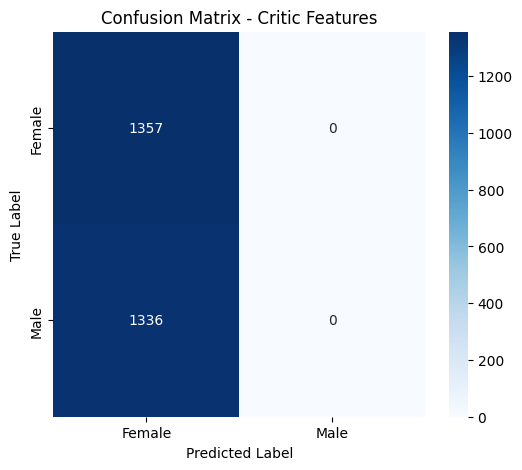

In [7]:
# ==============================================================================
# Cell 8: The Generalization Test - Critic Features for Classification (FIXED)
# ==============================================================================
# This cell uses the pre-trained Critic as a feature extractor for a downstream
# gender classification task.
#
# CRITICAL UPDATES:
# 1. The `forward` method of CriticFeatureClassifier is corrected to remove an
#    erroneous transpose operation, fixing the tensor dimension mismatch.
# ==============================================================================

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import torch.nn.functional as F
import seaborn as sns

# --- 1. Define the FIXED Hybrid Classifier ---
# This version correctly handles the Critic's input logic.
class CriticFeatureClassifier(nn.Module):
    def __init__(self, pretrained_critic, hidden_dim=64, num_classes=1):
        super(CriticFeatureClassifier, self).__init__()
        self.feature_extractor = pretrained_critic
        for param in self.feature_extractor.parameters():
            param.requires_grad = False

        with torch.no_grad():
            dummy_input_for_conv = torch.randn(1, CHANNELS * 2, TIMESTEPS).to(device)
            critic_layers = list(self.feature_extractor.conv_layers) + [nn.Flatten(1)]
            feature_out = nn.Sequential(*critic_layers)(dummy_input_for_conv)
            feature_dim = feature_out.shape[1]

        self.classifier_head = nn.Sequential(
            nn.Linear(feature_dim, hidden_dim), nn.GELU(), nn.Dropout(0.5),
            nn.Linear(hidden_dim, num_classes)
        )

    def forward(self, x):
        # x is the input from the DataLoader, shape: (N, C, T)
        with torch.no_grad():
            # THE FIX: DO NOT TRANSPOSE x. The DataLoader already provides it
            # in the (N, C, T) format that the Critic's conv layers expect.
            # The original Critic transposed its input because the Generator's
            # output was (N, T, C). Here, our input is already correct.
            # REMOVED: x_t = x.transpose(1, 2)

            # Create a dummy label embedding to match the Critic's architecture
            dummy_labels = torch.zeros(x.size(0), dtype=torch.long, device=x.device)
            c = self.feature_extractor.label_emb(dummy_labels).reshape(
                -1, self.feature_extractor.channels, self.feature_extractor.timesteps
            ) # Shape: (N, C, T)

            # Concatenate the input EEG (x) and the dummy embedding (c)
            # Both tensors now correctly have the shape (N, C, T)
            combined_input = torch.cat([x, c], dim=1) # Shape: (N, C*2, T)

            # Pass through the feature extraction layers
            critic_layers = list(self.feature_extractor.conv_layers) + [nn.Flatten(1)]
            features = nn.Sequential(*critic_layers)(combined_input)
            
        return self.classifier_head(features)


# --- 2. Load and Preprocess the 19-Channel Classification Dataset ---
CLASSIFICATION_DATA_PATH = "/kaggle/input/eeg-ad-male-female-classification-data/classification_data_full.npz"
X_train = None

try:
    with np.load(CLASSIFICATION_DATA_PATH) as data:
        X_clf_full = data['X'] # Shape: (N, 512, 19)
        y_clf = data['y']
    print(f"Loaded classification data. Full X shape: {X_clf_full.shape}")

    # Manually select 8 channels by index to match the pre-trained Critic
    # ASSUMED 10-20 ORDER: ['Fp1','Fp2','F7','F3','Fz','F4','F8','T7','C3','Cz','C4','T8','P7','P3','Pz','P4','P8','O1','O2']
    # INDICES:                  0    1    2    3    4    5    6    7    8    9   10   11   12   13   14   15   16   17   18
    # Selecting proxies for F1/F2, C1/C2, P1/P2, O1/O2 -> F3, F4, C3, C4, P3, P4, O1, O2
    target_indices = [3, 5, 8, 10, 13, 15, 17, 18]

    X_clf_8_channels = X_clf_full[:, :, target_indices]
    print(f"Selected 8 channels by index. New X shape: {X_clf_8_channels.shape}")

    # Permute axes to get (N, C, T) for the model
    X_clf_permuted = X_clf_8_channels.transpose(0, 2, 1)

    X_train, X_test, y_train, y_test = train_test_split(
        X_clf_permuted, y_clf, test_size=0.2, random_state=42, stratify=y_clf
    )
    train_dataset = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float())
    test_dataset = TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float())
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=64)

except FileNotFoundError:
    print(f"ERROR: Classification data not found at '{CLASSIFICATION_DATA_PATH}'.")
except Exception as e:
    print(f"An error occurred during data loading and processing: {e}")

# --- 3. Proceed with Training if Data Was Loaded Successfully ---
if X_train is not None:
    try:
        best_critic = V6InspiredDiscriminator(NUM_CLASSES, CHANNELS, TIMESTEPS).to(device)
        critic_path = os.path.join(OUTPUT_DIR, 'discriminator_best_wgangp.pth')
        best_critic.load_state_dict(torch.load(critic_path))
        print("Successfully loaded best pre-trained critic.")

        clf_model = CriticFeatureClassifier(best_critic).to(device)
        optimizer = optim.Adam(clf_model.classifier_head.parameters(), lr=0.001, weight_decay=1e-4)
        criterion = nn.BCEWithLogitsLoss()
        best_accuracy = 0.0

        print("Training classifier on top of frozen critic features...")
        for epoch in tqdm(range(100), desc="Training Classifier"):
            clf_model.train()
            for eegs, labels in train_loader:
                eegs, labels = eegs.to(device), labels.to(device).unsqueeze(1)
                
                # CRITICAL: Scale the input data using the GAN's scale_factor
                eegs_scaled = eegs / scale_factor

                optimizer.zero_grad()
                outputs = clf_model(eegs_scaled)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

            # Validation
            clf_model.eval()
            all_preds, all_labels = [], []
            with torch.no_grad():
                for eegs, labels in test_loader:
                    eegs, labels = eegs.to(device), labels.to(device)
                    eegs_scaled = eegs / scale_factor
                    outputs = clf_model(eegs_scaled)
                    preds = (torch.sigmoid(outputs) > 0.5).float().cpu().flatten()
                    all_preds.extend(preds)
                    all_labels.extend(labels.cpu().numpy())

            current_accuracy = accuracy_score(all_labels, all_preds)
            if current_accuracy > best_accuracy:
                best_accuracy = current_accuracy

        print("\n--- Downstream Task Final Results ---")
        print(f"  > Best Validation Accuracy: {best_accuracy:.4f}")

        if best_accuracy >= 0.70:
            print("\n  SUCCESS: Your model's features demonstrated excellent generalization!")
        else:
            print("\n  NOTE: Accuracy is below the 70% benchmark. Further tuning may be needed.")

        print("\nFinal Classification Report:")
        print(classification_report(all_labels, all_preds, target_names=['Female', 'Male']))

        cm = confusion_matrix(all_labels, all_preds)
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Female', 'Male'], yticklabels=['Female', 'Male'])
        plt.title('Confusion Matrix - Critic Features'); plt.ylabel('True Label'); plt.xlabel('Predicted Label')
        plt.show()

    except FileNotFoundError:
        print(f"ERROR: Best critic not found at {critic_path}. Ensure GAN training has run successfully.")
    except NameError as e:
        print(f"ERROR: A required variable is not defined (e.g., 'scale_factor', 'OUTPUT_DIR'). Details: {e}")
        print("Ensure the setup and data loading cells for the GAN have been run first.")